In [10]:
# If running in Google Colab, mount drive
print('Check if running in Colab...')
try:
    from google.colab import drive
    print('Running in Colab!')
    drive.mount('/content/drive')
    %cd '/content/drive/My Drive/CIL-FS20'
except ImportError:
    print('Running locally!')

    #Check python version
    from platform import python_version
    print('Current python version: {}'.format(python_version()))

    # Check available GPUs
    import tensorflow as tf
    no_GPUs_available = len(tf.config.experimental.list_physical_devices('GPU'))
    print("Number of GPUs Available: {}".format(no_GPUs_available))

Check if running in Colab...
Running locally!
Current python version: 3.7.7
Number of GPUs Available: 0


In [11]:
import numpy as np
import pandas as pd
import os

import keras
import random
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import concatenate
from keras.layers import BatchNormalization, Activation
from keras.backend import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

from util.mask_to_submission import masks_to_submission
import util.metrics as metrics
import util.utility as util
import util.post_processing as pp

## Install the following packages
import imageio
import natsort
import logging

## Constants

In [12]:
# Name of the current model
MODEL_NAME = 'final_model'
IMG_WIDTH = 608
IMG_HEIGHT = 608
EPOCHS = 100
STEPS_PER_EPOCH = 750
LEARNING_RATE = 0.0001
BATCH_SIZE = 2          # 8 on Leonhard
VALIDATION_SPLIT = 0.1
rnd_seed = 4
np.random.seed(rnd_seed)

## Load Images

In [13]:
logging.info('Loading training and test images')
training_image_dir = "training_images/images/"
training_label_dir = "training_images/groundtruth/"
test_image_dir = "test_images/normal/"
rotated_test_image_dir = "test_images/rotated/"

files_image = os.listdir(training_image_dir)
files_image = natsort.natsorted(files_image)
files_image_original = files_image[-10:]
files_image_extra = files_image[:5]

files_label = os.listdir(training_label_dir)
files_label = natsort.natsorted(files_label)
files_label_original = files_label[-10:]
files_label_extra = files_label[:5]

files_test = os.listdir(test_image_dir)
files_test = natsort.natsorted(files_test)

# Load Images and labels
training_image_original = util.load_images(training_image_dir, files_image_original, "RGB")
training_image_extra = util.load_images(training_image_dir, files_image_extra, "RGB")
training_label_original = util.load_images(training_label_dir, files_label_original, "L")
training_label_extra = util.load_images(training_label_dir, files_label_extra, "L")
# test_image = util.load_images(test_image_dir, files_test, "RGB")
test_image_list = pp.prepare_test_images(len(files_test), test_image_dir, files_test, rotated_test_image_dir)
test_image = np.array(test_image_list)

print("TRAINING:")
print(training_image_original.shape)
print(training_label_original.shape)
print(training_image_extra.shape)
print(training_label_extra.shape)
print("TEST:")
print(test_image.shape)

Loading 10 images
Loading 5 images
Loading 10 images
Loading 5 images
Rotating 94 test images
TRAINING:
(10, 400, 400, 3)
(10, 400, 400)
(5, 608, 608, 3)
(5, 608, 608)
TEST:
(752, 608, 608, 3)


## Preprocess Images
- Training images have size 400x400 and test images have size 608x608. So we
  need to pad training images to same size, for that we use mirror padding for now.
- Get a validation set of untouched original training images.
- Augment original training data with vertical and horizontal flips and 45 degrees
  rotations.
- Also augment validation set to get a better average performance.
- Rescale images

(14, 608, 608, 3)
(14, 608, 608, 1)
(1, 608, 608, 3)
(1, 608, 608, 1)


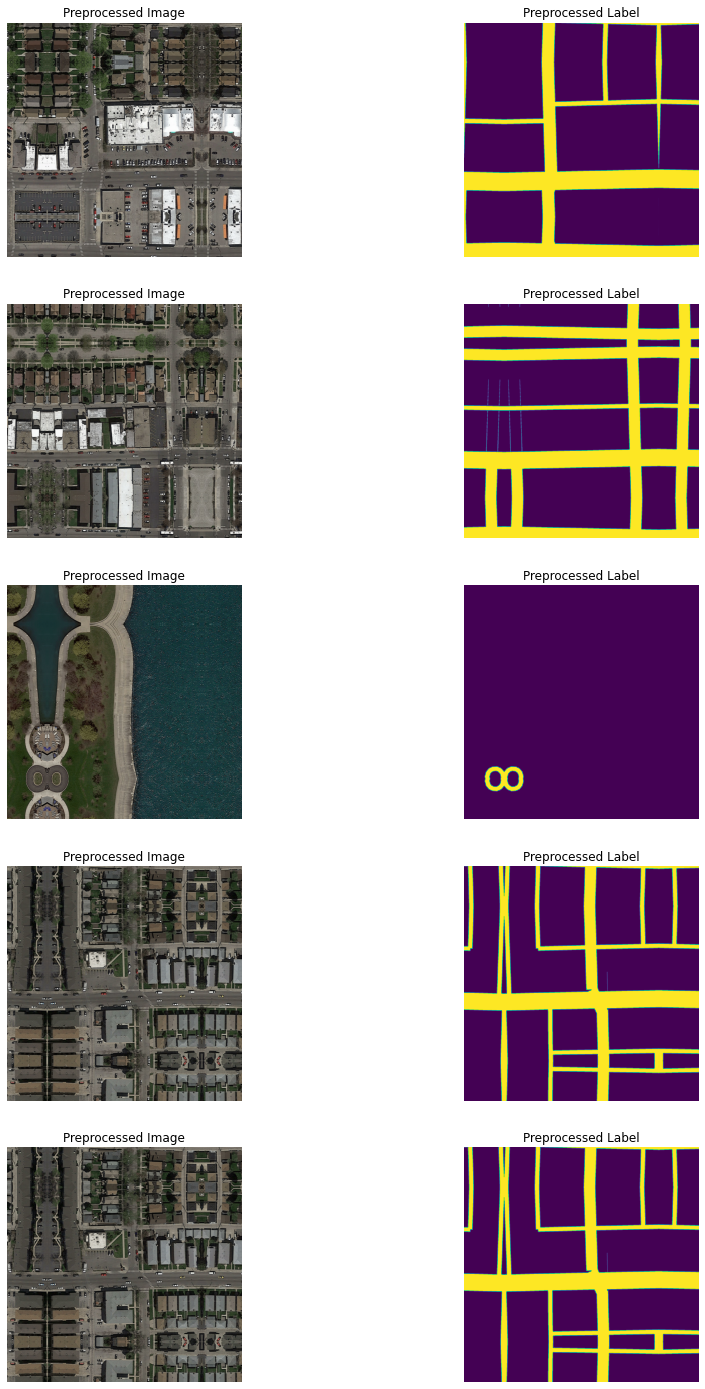

In [14]:
# Mirror padd all training images to get same size as test images
training_image_original = util.padd_images(training_image_original, 608, 608).astype(np.uint8)
training_image_extra = util.padd_images(training_image_extra, 608, 608).astype(np.uint8)
training_label_original = util.padd_images(training_label_original, 608, 608).astype(np.uint8)
training_label_extra = util.padd_images(training_label_extra, 608, 608).astype(np.uint8)

# Create a validation set
training_image_original, validation_image, training_label_original, validation_label = train_test_split(
    training_image_original, training_label_original, test_size=VALIDATION_SPLIT, random_state=rnd_seed)

# Pre-augment original training data to make original dataset
# more significant than self generated dataset. Augment validation set, so we need
# to sacrifice less training images for validation.
# only Augment original Data if running on Leonhard, as it uses a lot of RAM

#training_image_original = util.add_flipped_images(training_image_original)
#training_label_original = util.add_flipped_images(training_label_original)
#validation_image = util.add_flipped_images(validation_image)
#validation_label = util.add_flipped_images(validation_label)

#training_image_original = util.add_rotated_images(training_image_original)
#training_label_original = util.add_rotated_images(training_label_original)
#validation_image = util.add_rotated_images(validation_image)
#validation_label = util.add_rotated_images(validation_label)

training_image = np.concatenate((training_image_original, training_image_extra), axis=0)
training_label = np.concatenate((training_label_original, training_label_extra), axis=0)
training_label = np.expand_dims(training_label, -1)
validation_label = np.expand_dims(validation_label, -1)

# Rescale validation images/labels and test images because generator will do the same with training data
training_image = training_image.astype(np.float32)/255.0
training_label = training_label.astype(np.float32)/255.0
validation_image = validation_image.astype(np.float32)/255.0
validation_label = validation_label.astype(np.float32)/255.0
test_image = test_image.astype(np.float32)/255.0
logging.info('Finished Preprocessing!')

print(training_image.shape)
print(training_label.shape)
print(validation_image.shape)
print(validation_label.shape)

# Plot random Sample of images
n = training_image.shape[0]
index = random.randint(0, n-1)
num_samples = 5

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*2, 2):
  index = random.randint(0, n-1)

  f.add_subplot(num_samples, 2, i)
  plt.imshow(training_image[index])
  plt.title("Preprocessed Image")
  plt.axis('off')

  f.add_subplot(num_samples, 2, i+1)
  plt.imshow(np.squeeze(training_label[index]))
  plt.title("Preprocessed Label")
  plt.axis('off')

plt.show()

## Keras Datagenerator

We use the Keras Data Generator to additionally augment our training set online while training.

In [15]:
# We create an instance for the training images, training labels and test images
data_gen_args = dict(width_shift_range=0.1,
                     height_shift_range=0.1,
                     #zoom_range=0.05,
                     #shear_range=0.05,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_generator = image_datagen.flow(
    training_image,
    batch_size=BATCH_SIZE,
    seed=seed)
mask_generator = mask_datagen.flow(
    training_label,
    batch_size=BATCH_SIZE,
    seed=seed)

# Combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

## Model: Fully CNN built in Keras

In [7]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))

conv1 = util.convolutional_block(inputs, 16)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = util.convolutional_block(pool1, 32)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = util.convolutional_block(pool2, 64)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = util.convolutional_block(pool3, 128)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = util.convolutional_block(pool4, 256)
pool5 = MaxPooling2D(pool_size=(2,2)) (conv5)

conv6 = util.convolutional_block(pool5, 512)

up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
concat7 = concatenate([up7, conv5])
conv7 = util.convolutional_block(concat7, 256)

up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
concat8 = concatenate([up8, conv4])
conv8 = util.convolutional_block(concat8, 128)

up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
concat9 = concatenate([up9, conv3])
conv9 = util.convolutional_block(concat9, 64)

up10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv9)
concat10 = concatenate([up10, conv2])
conv10 = util.convolutional_block(concat10, 32)

up11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv10)
concat11 = concatenate([up11, conv1])
conv11 = util.convolutional_block(concat11, 16)
conv12 = Conv2D(1, (1, 1), activation='sigmoid')(conv11)

model = Model(inputs=inputs, outputs=conv12)
model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 608, 608, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

## Model Training

In [9]:
model_path = "./Models/{}.h5".format(MODEL_NAME)
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

csv_logger = CSVLogger("./Logs/{}_log.csv".format(MODEL_NAME), separator=',', append=False)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=6,
                               verbose=1,
                               epsilon=1e-4)

early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

#opt = keras.optimizers.adam(LEARNING_RATE)
opt = keras.optimizers.Nadam(lr=LEARNING_RATE)

model.compile(
      optimizer=opt,
      loss=metrics.combined_loss,
      metrics=[metrics.iou_coef])

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [ ]:
history = model.fit_generator(train_generator,
                              validation_data =(validation_image, validation_label),
                              steps_per_epoch=STEPS_PER_EPOCH,
                              epochs=EPOCHS,
                              callbacks = [checkpointer, csv_logger, lr_reducer, early_stopper])

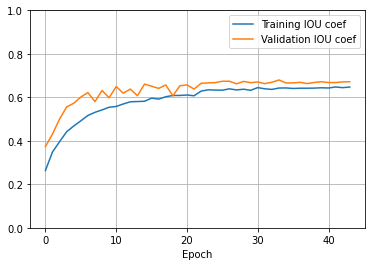

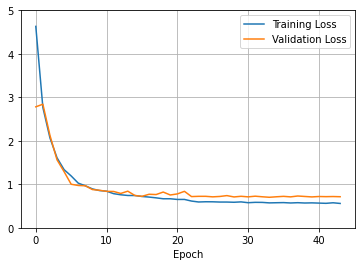

In [8]:
# Show a training report
training_info = pd.read_csv('./Logs/{}_log.csv'.format(MODEL_NAME), header=0)

acc1, = plt.plot(training_info['epoch'], training_info['iou_coef'])
acc2, = plt.plot(training_info['epoch'], training_info['val_iou_coef'])
plt.legend([acc1, acc2], ['Training IOU coef', 'Validation IOU coef'])
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.grid(True)
plt.show()

loss1, = plt.plot(training_info['epoch'], training_info['loss'])
loss2, = plt.plot(training_info['epoch'], training_info['val_loss'])
plt.legend([acc1, acc2], ['Training Loss', 'Validation Loss'])                            
plt.xlabel('Epoch')
plt.ylim(0,5)
plt.grid(True)

plt.show()

## Model Evaluation

In [16]:
# Kaggle scores on validation images (mean score per image and overall mean score)
model = load_model("./Models/{}.h5".format(MODEL_NAME), custom_objects={'combined_loss': metrics.combined_loss, 'iou_coef': metrics.iou_coef})
y_pred = model.predict(validation_image, batch_size=4, verbose=1)
scores = util.validate_kaggle_score(validation_label, y_pred)
print(sum(scores)/len(scores))

1/1 [==============================] - 3s 3s/step
0.9522952295229522


In [17]:
model = load_model("./Models/{}.h5".format(MODEL_NAME), custom_objects={'combined_loss': metrics.combined_loss, 'iou_coef': metrics.iou_coef})
predictions = model.predict(test_image, batch_size=4, verbose=1)



752/752 [==============================] - 886s 1s/step


In [29]:
# Post Processing
# import importlib
# importlib.reload(util.post_processing)
MODE = 'only90_max'
RESULT_DIR = 'test_images/post_processed/'

# combine all 8 predicted Images with MODE and save to RESULT_DIR
pp.combine_and_save(MODE, RESULT_DIR, predictions, files_test)

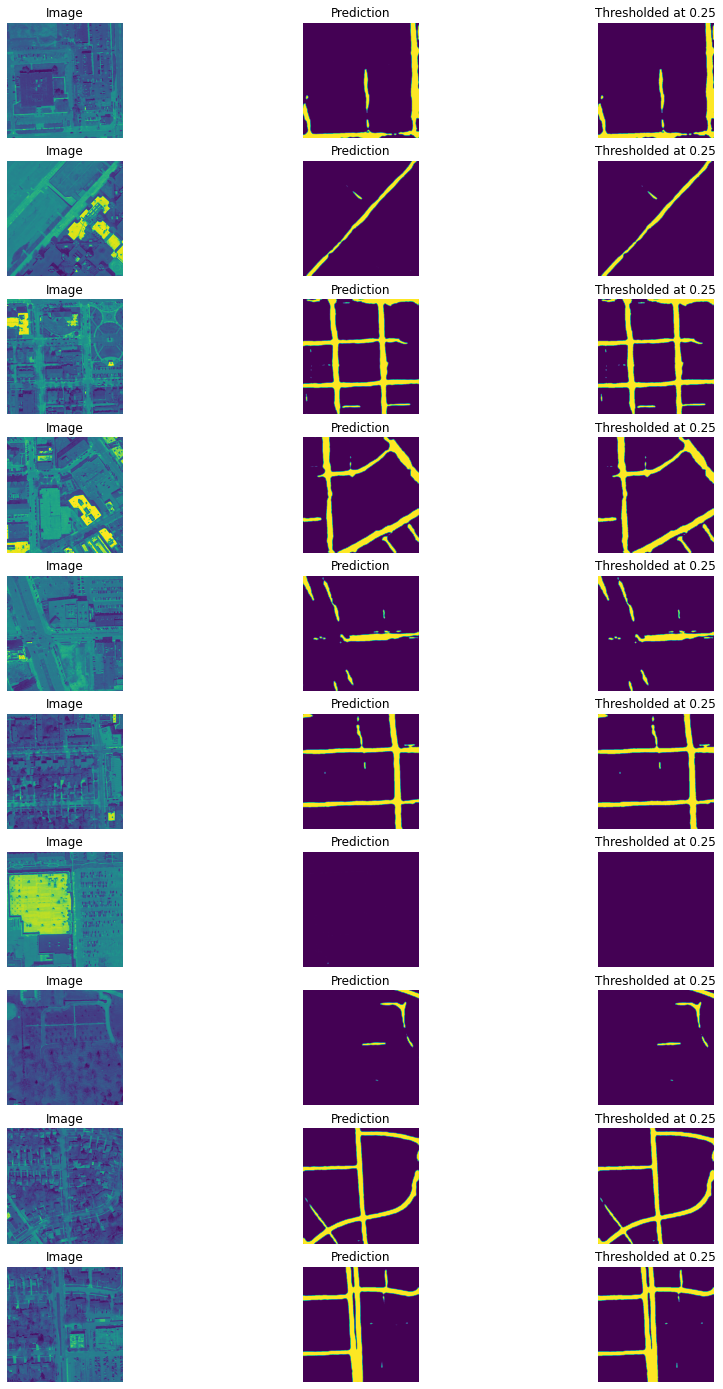

In [17]:
# Plot Predictions
thresh_val = 0.25
predicton_threshold = (predictions > thresh_val).astype(np.uint8)
index = random.randint(0, len(predictions)-1)
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*3, 3):
  index = random.randint(0, len(predictions)-1)

  f.add_subplot(num_samples, 3, i)
  plt.imshow(test_image[index][:,:,0])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+1)
  plt.imshow(np.squeeze(predictions[index][:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+2)
  plt.imshow(np.squeeze(predicton_threshold[index][:,:,0]))
  plt.title("Thresholded at {}".format(thresh_val))
  plt.axis('off')

plt.show()

## Create Submission File

In [30]:
result_dir = './Results/Prediction_Images/{}/'.format(MODEL_NAME)
result_dir = './test_images/post_processed_90max/'
submission_filename = './Results/Submissions/{}.csv'.format(MODEL_NAME)
import importlib
importlib.reload(util)
util.create_submission(predictions, result_dir, submission_filename, files_test)

./test_images/post_processed_90max/test_10.png
./test_images/post_processed_90max/test_105.png
./test_images/post_processed_90max/test_106.png
./test_images/post_processed_90max/test_107.png
./test_images/post_processed_90max/test_108.png
./test_images/post_processed_90max/test_11.png
./test_images/post_processed_90max/test_115.png
./test_images/post_processed_90max/test_116.png
./test_images/post_processed_90max/test_12.png
./test_images/post_processed_90max/test_121.png
./test_images/post_processed_90max/test_122.png
./test_images/post_processed_90max/test_123.png
./test_images/post_processed_90max/test_124.png
./test_images/post_processed_90max/test_128.png
./test_images/post_processed_90max/test_129.png
./test_images/post_processed_90max/test_130.png
./test_images/post_processed_90max/test_131.png
./test_images/post_processed_90max/test_136.png
./test_images/post_processed_90max/test_137.png
./test_images/post_processed_90max/test_138.png
./test_images/post_processed_90max/test_139